In [1]:
#load up the basics
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#image file issue
#https://stackoverflow.com/questions/48395076/keras-giving-oserror-image-file-is-truncated-26-bytes-not-processed
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model


#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")
    


TF version: 2.3.2
 GPU: /device:GPU:0


In [2]:
# build the generator build data generators for training and validaton

# here are the numbers for each storms, if we want to break those out for par. processing.
#(vs. running entire dir of all storms).
# Barry, 8900
# Delta, 9785
# Dorian, 24749
# Florence, 31434
# Gordon, 2019
# Isaias, 8938
# Laura, 24165
# Michael, 9600
# Sally, 6390
# Zeta, 8644
# pred_data_dir = '/data/NOAA_ERI/Florence'


# Define dirs and files
train_data_dir = '/data/NOAA_ERI/'

split = 0.2

total_train = 108200
total_val = 27045



# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 32

#latent_dim
z_dim = 1000

#set Image size (RGB so imshape is 3)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'input',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'input',
                                                        target_size = imsize,
                                                        subset='validation')

# define the metrics
#acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

Found 108200 images belonging to 13 classes.
Found 27045 images belonging to 13 classes.


In [3]:
#load or build model
##########

input = layers.Input(imshape)

x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(input)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)

x = layers.Flatten()(x)
x = layers.Dense(z_dim)(x)

x = layers.Dense(32*32*32, activation = "relu")(x)
x = layers.Reshape((32,32,32))(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(3,3, activation = "sigmoid", padding = "same")(x)



autoencoder = Model(input,x)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy")
autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)             

In [3]:
# define a callback

the_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./models/AE1000day2_checkpoint_{epoch:02d}-{val_loss:.2f}.h5')]
    
    
#     tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
#                                              patience = 10, 
#                                              restore_best_weights = True)



In [5]:
filepath = './models/AE1000_checkpoint_06-0.58.h5'
#load model
autoencoder = tf.keras.models.load_model(filepath, compile = True)

In [6]:
workfolk = 24

history = autoencoder.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 5,
                    validation_steps =  total_val // batch_size,
                    workers = workfolk,
                    max_queue_size = 6 * workfolk,
                    callbacks = the_callbacks)


Epoch 1/5
3381/3381 [==============================] - 3506s 1s/step - loss: 0.5769 - val_loss: 0.5782
Epoch 2/5
3381/3381 [==============================] - 3457s 1s/step - loss: 0.5769 - val_loss: 0.5781
Epoch 3/5
3381/3381 [==============================] - 3521s 1s/step - loss: 0.5768 - val_loss: 0.5781
Epoch 4/5
3381/3381 [==============================] - 3581s 1s/step - loss: 0.5768 - val_loss: 0.5781
Epoch 5/5
3381/3381 [==============================] - 3605s 1s/step - loss: 0.5768 - val_loss: 0.5781


In [7]:
#test model

def ShowAEResult(im):
    img = tf.keras.preprocessing.image.load_img(im,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)

    predicted = autoencoder.predict(img)


    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(tf.keras.preprocessing.image.load_img(im, target_size = imsize))
    plt.subplot(122)
    plt.imshow(np.squeeze(predicted))

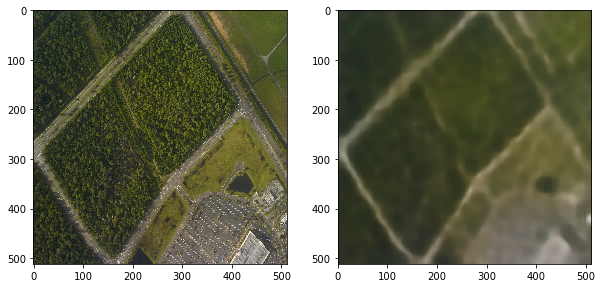

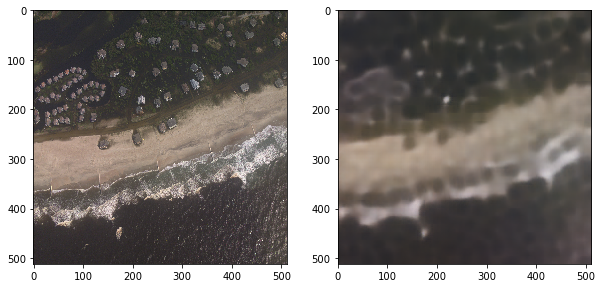

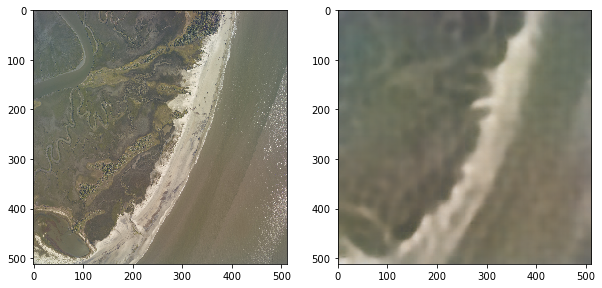

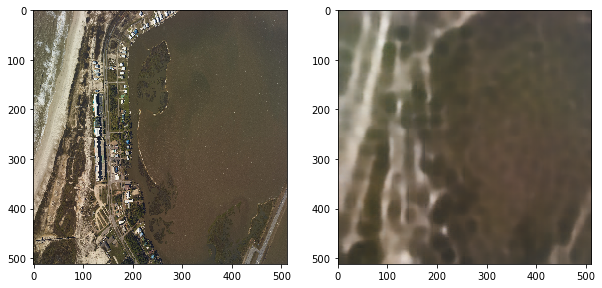

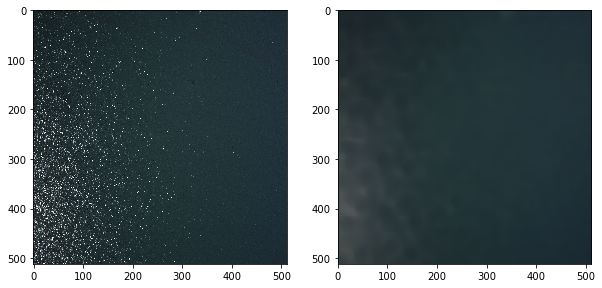

In [8]:
# examples from Florence, Dorian, Zeta, 
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048812.jpg")
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055088.jpg")
ShowAEResult("/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg")
ShowAEResult("/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360377.jpg")
ShowAEResult("/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018922-0824211724470-RGB2.jpg")

In [9]:
#save the model
filepath = './models/Autoencoder1000_day2'
autoencoder.save(filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/Autoencoder1000_day2/assets


In [17]:
#remove the decoder
encoder = tf.keras.models.Sequential(autoencoder.layers[:-7])
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              32769000  
Total params: 32,797,640
Trainable params: 32,797,640
Non-trainable params: 0
__________________________________________

In [21]:
im = "/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg"
img = tf.keras.preprocessing.image.load_img(im,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)


Dims = encoder.predict(img)
print(Dims)

[[-1.90693414e+00 -5.58501720e-01 -5.84208608e-01  1.82265151e+00
  -8.49215031e-01 -9.47441339e-01  7.74369299e-01 -4.82322097e-01
   1.01210439e+00 -2.68464451e+01  9.49263334e-01  1.08180106e+00
  -1.26158744e-01  2.13741496e-01  2.41184616e+00  6.76175281e-02
  -2.96304077e-01 -9.74991441e-01  8.09908748e-01  7.11913526e-01
   3.17530894e+00  1.39550531e+00 -5.68405867e-01  2.16633821e+00
  -1.58861071e-01  3.33805889e-01 -7.83217192e-01  4.62197810e-01
  -2.01063395e+00 -8.98909986e-01  1.17814982e+00 -1.01895618e+00
   3.20635438e-01 -4.14233476e-01  6.10753447e-02  2.82238436e+00
   4.12275761e-01 -4.97164726e-01  3.33727598e-01  1.77359128e+00
  -6.35674715e-01 -5.87203801e-01 -1.14163184e+00  3.19038570e-01
  -3.00548971e-01  1.11228907e+00 -1.16765916e+00 -1.77132833e+00
   4.76469874e-01 -1.46267307e+00  9.38055515e-02  1.89985907e+00
  -3.06445248e-02 -1.59974825e+00  7.18193471e-01 -1.38164687e+00
  -3.94233525e-01 -2.50430524e-01 -9.16118547e-02 -6.68529093e-01
   1.03926

In [57]:
# build the predict generator.

# here are the numbers for each storms, if we want to break those out for par. processing.
#(vs. running entire dir of all storms).
# Barry, 8900
# Delta, 9785
# Dorian, 24749
# Florence, 31434
# Gordon, 2019
# Isaias, 8938
# Laura, 24165
# Michael, 9600
# Sally, 6390
# Zeta, 8644
# Ida
# Henri
# pred_data_dir = '/data/NOAA_ERI/Florence'


#directory
pred_data_dir = '/data/NOAA_ERI/'

batch_size = 32

#set Image size based on the model(RGB, so 3 channels)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

#rescale the images
pred_datagen = ImageDataGenerator(rescale =1./255.)

# Flow images in batches 
pred_generator = pred_datagen.flow_from_directory(pred_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = None,
                                                    target_size = imsize,
                                                    shuffle = False)
#reset the generator counter
pred_generator.reset()

Found 135245 images belonging to 13 classes.


In [ ]:
#set number of images based on output of previous cell
numberofimages = 135245

workfolk = 24

#make the predictions
LD_prediction = encoder.predict(pred_generator,
                           verbose=1,
                           steps=numberofimages/batch_size,
                           workers = workfolk,
                           max_queue_size = 6 * workfolk)

1799/4226 [===========>..................] - ETA: 33:11

In [56]:
#get the filenames
filenames = pred_generator.filenames

#convert the predictions to a list
PredList = LD_prediction.tolist()

#and make a dataframe with filenames adn predictions
PredDF = pd.concat([pd.DataFrame(filenames), pd.DataFrame(PredList)], axis = 1)

PredDF.head()

,0,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,20180906a_jpgs/jpgs/P24951476.jpg,-0.125820,0.170557,-0.091087,-0.181141,0.009151,0.113987,0.073013,-0.226517,0.438933,...,-0.051799,-0.288818,0.006219,0.177536,-0.609068,-0.216941,-0.139377,0.314798,-0.050542,-0.022354
1,20180906a_jpgs/jpgs/P24951479.jpg,-0.207202,0.234354,0.129814,0.154781,-0.010463,-0.137843,0.033534,-0.363780,0.190508,...,0.020302,-0.264604,-0.006497,0.037565,-0.401338,-0.288806,-0.023245,-0.124784,-0.007472,0.033993
2,20180906a_jpgs/jpgs/P24951482.jpg,0.037271,0.223868,0.128348,0.017848,0.062367,0.131283,0.011642,-0.292170,0.194482,...,0.052838,0.181747,0.223328,0.238231,-0.102479,-0.249299,-0.105427,-0.187377,-0.110533,-0.239660
3,20180906a_jpgs/jpgs/P24951485.jpg,0.006544,-0.049886,-0.016953,0.121057,-0.467575,0.420064,0.630602,-0.161584,0.454872,...,0.586563,-0.559006,-0.313136,-0.017831,0.429645,-0.155654,0.018040,-0.503404,0.419542,0.063816
4,20180906a_jpgs/jpgs/P24951488.jpg,0.011442,1.047002,-0.010177,-1.031096,-0.491943,0.353562,1.134932,0.110557,-0.455322,...,0.331160,-1.406308,0.636505,0.971086,-0.862436,-0.474013,0.129403,0.171115,0.335334,0.495863


In [ ]:
#save the data

#new csv to save
newpredcsv = '../data/Autoencoder1000Embeddings.csv'

PredDF.to_csv(newpredcsv, index=False)